In [3]:
from __future__ import print_function, division
from builtins import range

import os

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import beta, norm
from IPython.display import Math, Latex
from matplotlib import figure
from ipywidgets import interact
from ipywidgets.embed import embed_minimal_html


import seaborn as sns

# for consistent results, set random seed
np.random.seed(42)

In [9]:
pd.options.display.max_columns = None

### 1. A proof of the Central Limit Theorem

Comparing Gaussian with Beta distributions

In [2]:
# parameters and hyperparameters
NUM_TRIALS = 501
true_cr = 0.146

# beta priors (non-informative, a.k.a uniform distribution)
a, b = 1, 1 

# indices for plotting steps
plot_indices = (10, 20, 30, 50, 100, 200, 500)

# array to store data
data = np.empty(NUM_TRIALS)

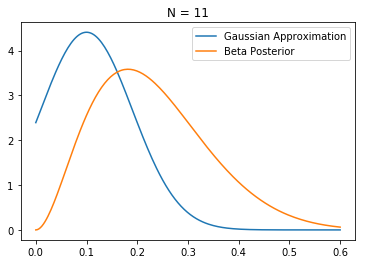

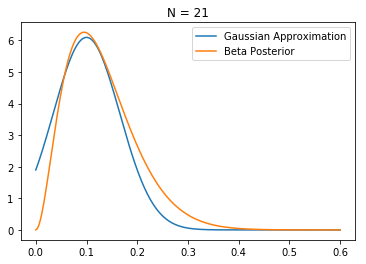

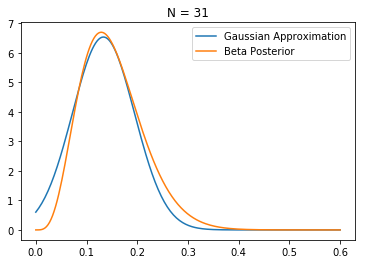

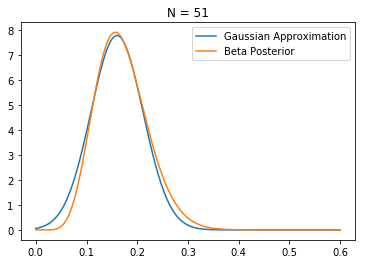

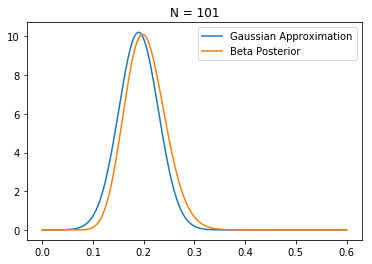

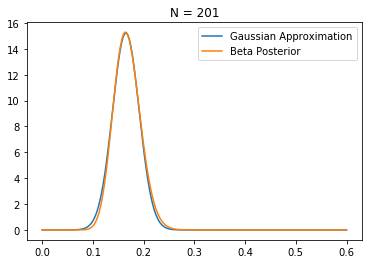

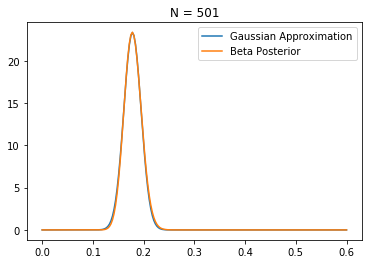

In [3]:
for i in range(NUM_TRIALS):
    '''draw a sample and store it'''
    x = 1 if np.random.random() < true_cr else 0
    data[i] = x
    
    '''update beta distribution'''
    a += x
    b += 1 - x
    
    '''estimate ctr mean, update number of samples, get standard deviation'''
    if i in plot_indices:
        p = data[:i].mean()
        n = i + 1
        std = np.sqrt(p * (1 - p) / n)
        
        '''Plot the gaussian'''
        _ = np.linspace(0, 0.6, 200)
        g = norm.pdf(_, loc = p, scale = std)
        plt.plot(_, g, label = 'Gaussian Approximation')
        
        '''Same thing for the Beta'''
        posterior = beta.pdf(_, a = a, b = b)
        plt.plot(_, posterior, label = 'Beta Posterior')
        plt.legend()
        
        '''Keep track'''
        plt.title('N = %s' % n)
        plt.show()
        

### 2. Step by Step modeling with PYMC3

In [105]:
import pymc3 as pm
import arviz as az
import scipy.stats as stats

In [92]:
real_data = [
    1, 1, 0, 0, 0, 1, 1, 1, 1, 1,
    0, 1, 0, 1, 0, 1, 0, 1, 1, 0,
    1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 0, 0, 0, 1, 1,
    0, 1, 0, 1, 1, 1, 0, 0, 1, 0,
    0, 1, 1, 0, 1, 1, 1, 0, 0, 0,
    1, 0, 1, 0, 0, 0, 0, 0, 0, 1,
    1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
    0, 1, 1, 1, 0, 0, 1, 0, 1, 1,
    1, 1, 1, 0, 0, 0, 1, 0, 1, 0
]

In [93]:
with pm.Model() as model_1:
    '''define the prior
    alpha = 2
    beta = 2
    '''
    theta = pm.Beta('theta', 2, 2)
    
    '''define the likelihood:
    tell the model how the likelihood works.
    Model will know that each session is a Bernoulli variable
    with parameter theta.
    Also, we pass the observed data as a list.
    '''
    data = pm.Bernoulli('data', theta, observed = real_data)
    
    ''' get the samples (trace)'''
    trace = pm.sample(return_inferencedata = True) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.
The acceptance probability does not match the target. It is 0.8795084747831097, but should be close to 0.8. Try to increase the number of tuning steps.


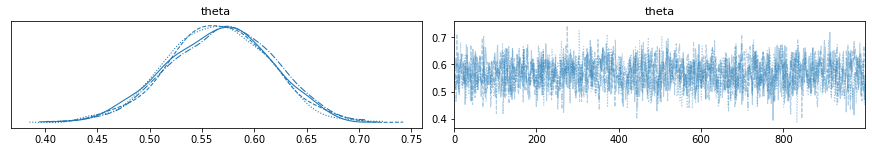

In [97]:
varnames = ['theta']
pm.traceplot(trace, varnames);

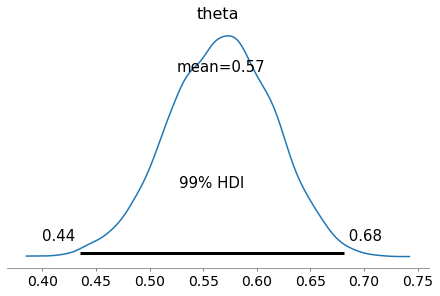

In [95]:
az.plot_posterior(trace, hdi_prob=0.99);

### 3. Step by Step Analysis with PYMC3

Example: BEST (Bayesian Estimation Supersedes T-Test) is an improved, Bayesian version of the T-Test.

In [99]:
df_nov = pd.read_csv(os.path.join('../data/processed', 'dating_november_cr.csv'),
                    parse_dates=['join_date'], index_col=[0])

df_nov.head()

,join_date,conversions,trials,cr,variant
0,2021-11-01,623,1967,31.67,first
1,2021-11-02,563,1848,30.47,first
2,2021-11-03,551,1977,27.87,first
3,2021-11-04,513,1788,28.69,first
4,2021-11-05,530,1872,28.31,first


#### 3.1 Prepare data

In [101]:
# real data
control_trials = df_nov[(df_nov['variant']=='first')]['trials']
control_converted = df_nov[(df_nov['variant']=='first')]['conversions']

experiment_trials = df_nov[(df_nov['variant']=='second')]['trials']
experiment_converted = df_nov[(df_nov['variant']=='second')]['conversions']

#### 3.2 Create models

In [102]:
#Model A (model for the control group)
with pm.Model() as model_A:
    '''prior distribution of probability of A'''
    p_A = pm.Uniform('p_A', lower=0, upper=1)
    
    '''fit the observed data '''
    obs = pm.Binomial("obs", n = control_trials, p = p_A, observed = control_converted)
    
    '''Markov chain '''
    step = pm.Metropolis()
    
    '''sampling from the posterior '''
    trace_A = pm.sample(30000, step=step)
    burned_trace_A = trace_A[1000:]
    
    
#Model B (model for the experiment group)
with pm.Model() as model_B:
    '''prior distribution of probability of B'''
    p_B = pm.Uniform('p_B', lower=0, upper=1)  
    
    '''fit the observed data '''
    obs = pm.Binomial("obs", n = experiment_trials, p = p_B, observed = experiment_converted)
    
    '''Markov chain ''' 
    step = pm.Metropolis()
    
    '''sampling from the posterior '''
    trace_B = pm.sample(30000, step=step)
    burned_trace_B = trace_B[1000:]

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [p_A]


Sampling 4 chains for 1_000 tune and 30_000 draw iterations (4_000 + 120_000 draws total) took 20 seconds.
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [p_B]


Sampling 4 chains for 1_000 tune and 30_000 draw iterations (4_000 + 120_000 draws total) took 19 seconds.
The number of effective samples is smaller than 10% for some parameters.


#### 3.3 Check Chains

/Users/danielsanchez/.virtualenv/lib/python3.9/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/Users/danielsanchez/.virtualenv/lib/python3.9/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


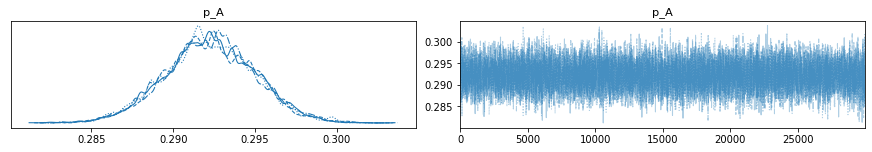

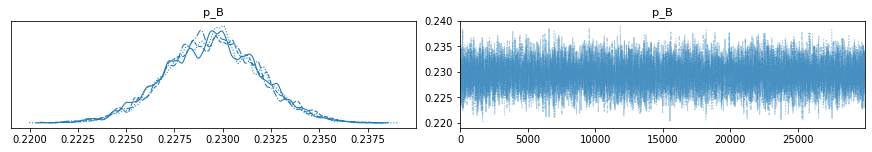

In [103]:
pm.traceplot(trace_A)
pm.traceplot(trace_B);

#### 3.4 Posteriors

In [108]:
samples_posterior_A = burned_trace_A['p_A']
samples_posterior_B = burned_trace_B['p_B']

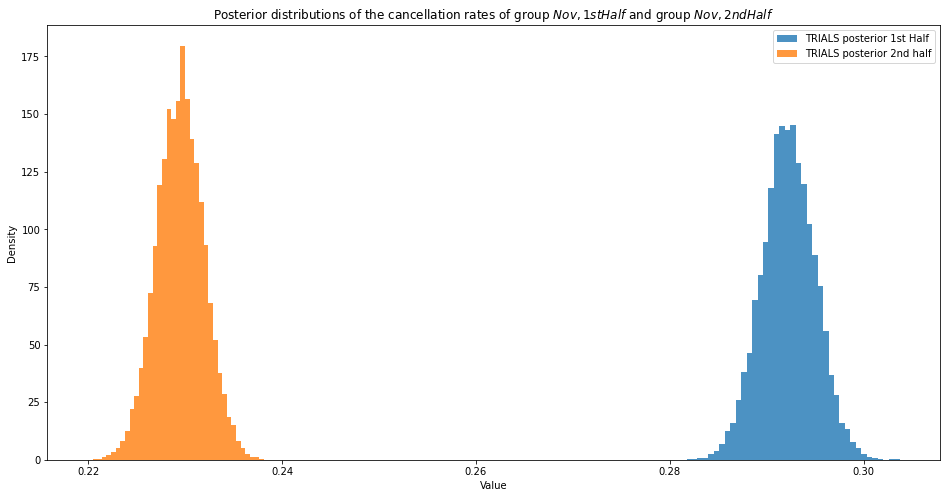

In [113]:
plt.rcParams["figure.figsize"] = (16,8)

plt.hist(samples_posterior_A, bins=40, label='TRIALS posterior 1st Half', density=True, alpha=0.8)
plt.hist(samples_posterior_B, bins=40, label='TRIALS posterior 2nd half', density=True, alpha=0.8)
plt.xlabel('Value')
plt.ylabel('Density')
plt.title("Posterior distributions of the cancellation rates of group $Nov, 1st Half$ and group $Nov, 2nd Half$")
plt.legend()
plt.show()

#### 3.5 Evaluate (by ROPE method)

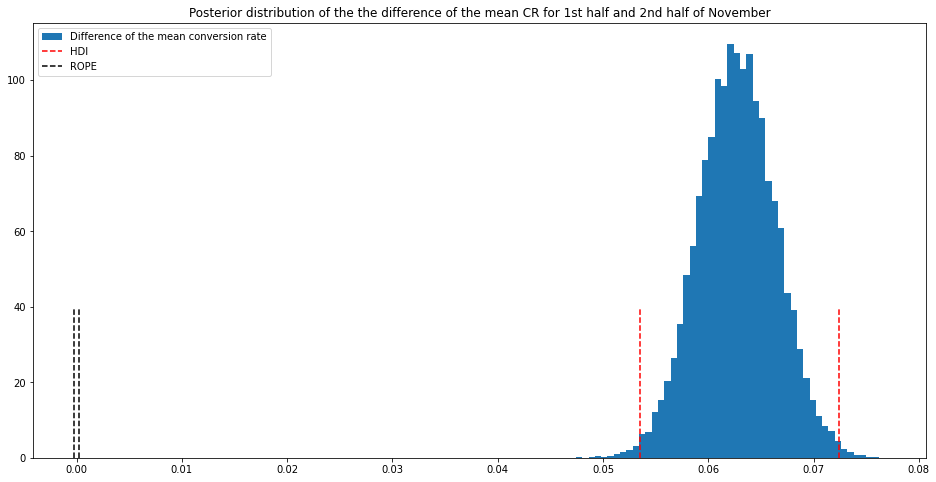

Null hypothesis rejected


In [118]:
difference = samples_posterior_A - samples_posterior_B 

'''the 99% HDI interval of the difference'''
hdi = pm.stats.hpd(difference, hdi_prob=0.99) 

'''region of practical equivalence ROPE;
as a t-test, we use std of response'''
rope = [-0.1*samples_posterior_A.std(), 0.1*samples_posterior_A.std()]

plt.hist(difference, bins=50, density=True, label='Difference of the mean conversion rate')
plt.title('Posterior distribution of the the difference of the means')
plt.vlines(hdi[0], 0,40, linestyle='--', color='red', label='HDI')
plt.vlines(hdi[1], 0, 40, linestyle='--', color='red')
plt.vlines(rope[0], 0, 40, linestyle='--', color='black', label='ROPE')
plt.vlines(rope[1], 0, 40, linestyle='--', color='black')
plt.title('Posterior distribution of the the difference of the mean CR for 1st half and 2nd half of November')
plt.legend(loc='upper left')
plt.show()

if rope[0] and rope[1] > hdi[1] or rope[0] and rope[1] < hdi[0]:
    print(f'Null hypothesis rejected')
else:
    print(f'Our data is not enough to make a conclusive decision')